# Problema do Caixeiro Viajante

Suponha que um caixeiro viajante tenha que visitar n cidades diferentes, iniciando e encerrando sua viagem na primeira cidade. Suponha, também, que não importa a ordem com que as cidades são visitadas e que de cada uma delas o caixeiro pode ir diretamente para qualquer outra. O problema do caixeiro viajante consiste em descobrir a rota que torna mínima a viagem total.


Exemplificando o caso n = 4:
<br>
Se tivermos quatro cidades 0, 1, 2 e 3. Uma rota que o caixeiro viajante deve considerar poderia ser:
<br>
Saia de 0 e vá para 1, de 1 vá para 2, e depois vá para 3 e então volte 0


Quais são as outras possibilidades? É fácil ver que existem seis rotas possíveis:
<br>• 01230
<br>• 01320
<br>• 02130
<br>• 02310
<br>• 03120
<br>• 03210

In [ ]:
import random as rd
from random import choices
import numpy as np

#apenas para a visualização própria
import networkx as nx
import matplotlib as plt

Quantas cidades o problema terá

In [ ]:
n_city = 6

Geração aleatória das distâncias de uma cidade à outra,

In [ ]:
G = nx.Graph() # visualização
#rd.seed(1) # para debug

# gerar distancias aleatorias para as cidades
cities = [i for i in range(n_city)]
city_distances = {}

for c1 in cities:
    for c2 in cities:
        if c1 != c2:
            distance = rd.randint(5, 100)
            city_distances[(c1,c2)] = distance
            city_distances[(c2,c1)] = distance
            G.add_edge(c1, c2, weight=distance)
        else: # c1 == c2
            city_distances[(c1,c2)] = 0
            break

#city_distances

Geração de um grafo para a visualização

{(1, 0): Text(0.30241756683435195, 0.29586901929644926, '81'),
 (1, 2): Text(-0.2601643608549651, -0.07984379929423321, '65'),
 (1, 3): Text(-0.6483498668705504, 0.058383335987441415, '34'),
 (1, 4): Text(0.03788598542580607, 0.5912361737148883, '89'),
 (1, 5): Text(-0.02518879201684457, 0.09627782530895651, '63'),
 (0, 2): Text(0.33895293972048757, -0.26493605750453375, '58'),
 (0, 3): Text(-0.0492325662950977, -0.12670892222285915, '5'),
 (0, 4): Text(0.6370032860012588, 0.40614391550458784, '87'),
 (0, 5): Text(0.5739285085586081, -0.08881443290134405, '80'),
 (2, 3): Text(-0.6118144939844148, -0.5024217408135416, '84'),
 (2, 4): Text(0.07442135831194172, 0.03043109691390533, '51'),
 (2, 5): Text(0.011346580869291079, -0.46452725149202656, '39'),
 (3, 4): Text(-0.3137641477036436, 0.16865823219557996, '21'),
 (3, 5): Text(-0.3768389251462942, -0.32630011621035193, '91'),
 (4, 5): Text(0.3093969271500623, 0.20655272151709506, '76')}

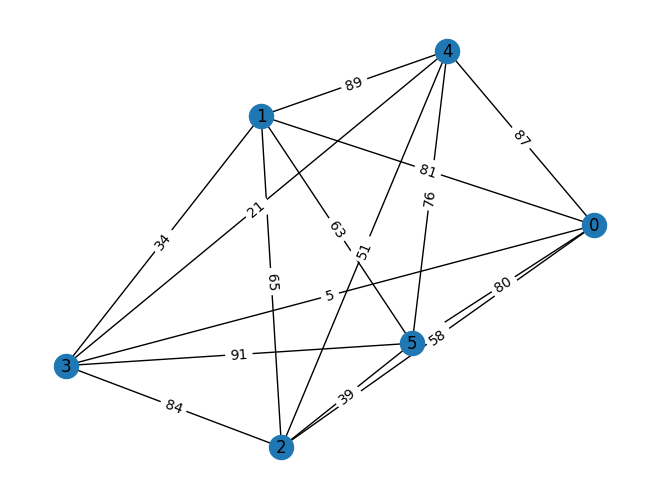

In [ ]:
#grafo para visualização
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

Geração de indivíduos, começando do 0, passando pelas outras cidades sem repetição e terminando em 0.

In [ ]:
# geração de individuos
def generate_population(n_ind = 1000):
    ind = []

    for i in range(n_ind):
        ind.append([0] + rd.sample(cities[1:], n_city-1) + [0])

    return ind
# ind

Função de fitness, é apenas um somatório das distâncias da cidade i até a cidade i + 1

In [ ]:
#função de fitness
def fitness(person):
    c = 0 # custo da caminhada

    for i in range(len(person) - 1):
        c += city_distances[person[i], person[i+1]]

    return c

Pega os fitness scores do vetor inteiro

In [ ]:
#vetor com os fitness
def get_fit_scores(ind):
    fit_scores = []
    for i in range(len(ind)):
        fit_scores.append(fitness(ind[i]))

    return fit_scores

Seleção por torneio, pega n_torneio individuos e seleciona os 2 melhores entre eles

In [ ]:
#seleção por torneio
# shuffle no vetor ("meio" que escolher 3 elementos aleatorios)
def tourney_selection(ind, fit_scores, n_torneio=6): #individuos participando no torneio
    contenders_index = rd.sample(range(0, len(ind)-1), n_torneio) # para realizar 2 torneios

    contenders=[]

    #   #############################################
    fit_scores_copy = fit_scores.copy()
    ind_copy = ind.copy()

    best_index = fit_scores_copy.index(min(fit_scores_copy)) #pega o index do menor valor no fit_scores
    parent1 = ind_copy[best_index]

    ind_copy.pop(best_index) #remove o pai 1 da lista de individuos
    fit_scores_copy.pop(best_index)

    best_index = fit_scores_copy.index(min(fit_scores_copy)) #pega o index do segundo menor valor no fit_scores
    parent2 = ind_copy[best_index]
    # #############################################
    # # outro metodo, talvez aumente a variabilidade genética

    #best significa o menor fit_score
    # best = fit_scores[contenders_index[0]]
    # best_index = 0
    # for i in range(1, int(n_torneio/2)):
    #     if fit_scores[contenders_index[i]] < best:
    #         best = fit_scores[contenders_index[i]]
    #         best_index = i
    # parent1 = ind[best_index]

    # best = fit_scores[contenders_index[int(n_torneio/2)]]
    # best_index = 0
    # for i in range(int(n_torneio/2), int(n_torneio)):
    #     if fit_scores[i] < best:
    #         best = fit_scores[contenders_index[i]]
    #         best_index = i
    # parent2 = ind[best_index]
    # #############################################

    return parent1, parent2

Crossover de 2 individuos, gera 2 filhos. A função funciona pegando metade do vetor de um pai e, de modo a não repetir as cidades, ele pega a ordem do outro pai das cidades remanescentes. Por exemplo:
<br> pai1: [1,4,3,2,0,6]
<br> pai2: [3,0,1,4,6,2]

<br> filho1: [1,4,3,0,6,2] ( o pai1 passa o 1,4,3, mas o resto é obtido na ordem do pai2 )
<br> filho2: [3,0,1,4,2,6]

In [ ]:
# pega 2 individuos, pega uma parte do 1 individuo e completa o resto com o 2 individuo, respeitando que não pode repetir cidade e respeitando a ordem do 2 individuo
def crossover(first, second):
    #cruzamento de 1 ponto
    new_first = [i for i in first if i not in second[0:int(len(second)/2 + 1)]]
    new_second = [i for i in second if i not in first[0:int(len(first)/2 + 1)]]
    new1 = [[0] + first[1:int(len(first)/2 + 1)] + new_second + [0]]
    new2 = [[0] + second[1:int(len(second)/2 + 1)] + new_first + [0]]
    return new1, new2

Aplica o crossover na população

In [ ]:
def crossover_everyone(ind, fit_scores, size): #size é a população da geração nova antes de entrar nessa funcao
    new_gen = []
    while(len(ind) > size + len(new_gen)):
        parent1, parent2 = tourney_selection(ind, fit_scores)
        c1, c2 = crossover(parent1, parent2)
        new_gen.append(c1[0])
        new_gen.append(c2[0])
    return new_gen

A mutação é definida por trocar 2 cidades

In [ ]:
#mutacao
def mutation(person):
    shuffle = rd.sample(range(1, len(person)-2), 2)
    person[shuffle[0]], person[shuffle[1]] = person[shuffle[1]], person[shuffle[0]]
    return person

Aplica a mutacao, de acordo com uma chance especificada, na população

In [ ]:
def mutation_everyone(ind, mutation_chance = 0.01):
    for i in range(len(ind)):
        if rd.random() < mutation_chance:
            ind[i] = mutation(ind[i])

Elitismo, garante que uma porcentagem da população específica dure durante as iterações, esses elites não sofrem mutação.

In [ ]:
def elitism(fit_scores, elite_percent=0.02):
    num_elites = max(1, int(len(fit_scores) * elite_percent))  # Pelo menos 1 elite

    # sort no vetor para pegar os mais adeptos
    sorted_indices = sorted(range(len(fit_scores)), key=lambda i: fit_scores[i])

    # Select the top 'num_elites' individuals as elites
    elites_indices = sorted_indices[:num_elites]

    return elites_indices

Código principal, definição dos parametros principais e o código irá printar, para cada geração, o melhor indivíduo daquela geração, seu index, seu fitness score e sua solução para o problema

In [ ]:
n_ind = 10
n_gen = 1000
ind = generate_population(n_ind=n_ind)
elite_percent=0.02
mutation_chance = 0.10

for _ in range(n_gen):
    new_ind = []
    rd.shuffle(ind) # shuffle tem que vir antes de fit_scores
    fit_scores = get_fit_scores(ind)

    # for i in range(int(len(ind)*0.2)): # uma parte da população fica
    #     new_ind.append(ind[i])

    elites = elitism(fit_scores, elite_percent=elite_percent)
    for elite in elites:  # 2% (modificavel) dos melhores ficam
        new_ind.append(ind[elite])
    print(f'index: {fit_scores.index(min(fit_scores))} score: {min(fit_scores)} solution: {ind[fit_scores.index(min(fit_scores))]}')

    # o resto é crossover
    new_ind = new_ind + crossover_everyone(ind, fit_scores, len(new_ind))

    mutation_everyone(new_ind[len(elites):], mutation_chance = mutation_chance) # mutacao na população
    ind = new_ind


index: 6 score: 285 solution: [0, 5, 1, 2, 4, 3, 0]
index: 0 score: 279 solution: [0, 3, 1, 5, 2, 4, 0]
index: 0 score: 279 solution: [0, 3, 1, 5, 2, 4, 0]
index: 0 score: 279 solution: [0, 3, 1, 5, 2, 4, 0]
index: 0 score: 279 solution: [0, 3, 1, 5, 2, 4, 0]
index: 0 score: 279 solution: [0, 3, 1, 5, 2, 4, 0]
index: 0 score: 279 solution: [0, 3, 1, 5, 2, 4, 0]
index: 0 score: 279 solution: [0, 3, 1, 5, 2, 4, 0]
index: 1 score: 279 solution: [0, 3, 1, 5, 2, 4, 0]
index: 0 score: 279 solution: [0, 3, 1, 5, 2, 4, 0]
index: 0 score: 279 solution: [0, 3, 1, 5, 2, 4, 0]
index: 0 score: 279 solution: [0, 3, 1, 5, 2, 4, 0]
index: 0 score: 279 solution: [0, 3, 1, 5, 2, 4, 0]
index: 0 score: 279 solution: [0, 3, 1, 5, 2, 4, 0]
index: 0 score: 279 solution: [0, 3, 1, 5, 2, 4, 0]
index: 0 score: 279 solution: [0, 3, 1, 5, 2, 4, 0]
index: 0 score: 279 solution: [0, 3, 1, 5, 2, 4, 0]
index: 0 score: 279 solution: [0, 3, 1, 5, 2, 4, 0]
index: 0 score: 279 solution: [0, 3, 1, 5, 2, 4, 0]
index: 0 sco

OBS: parece que com 6 cidades a solução é encontrada muito rapidamente, considere aumentar as cidades